In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('/Users/pchaberski/projects/image-embeddings')

In [3]:
import torch
from data.hm_data import HMDataset
import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [4]:
from utils.configuration import load_config
# from utils.logger import configure_logger
import neptune.new as neptune
import os
from data.hm_data_module import HMDataModule
from model.autoencoder_module import LitHMAutoEncoder
import pytorch_lightning as pl
from importlib import import_module

In [5]:
cfg = load_config('config.yml')

---

Test data class

In [6]:
data_train_scaled = HMDataset(
    data_path=os.path.join(cfg.get('data_path'), 'train'),
    image_size=cfg.get('image_size'),
    center=False,
    center_params=cfg.get('center_params')
)

data_train_centered = HMDataset(
    data_path=os.path.join(cfg.get('data_path'), 'train'),
    image_size=cfg.get('image_size'),
    center=True,
    center_params=cfg.get('center_params')
)

In [7]:
idx = 666

tens_scaled = data_train_scaled[idx]
tens_centered = data_train_centered[idx]

print('Original, scaled 0-1:')
print(torch.min(tens_scaled), torch.max(tens_scaled))
print('Center:')
print(torch.min(tens_centered), torch.max(tens_centered))

Original, scaled 0-1:
tensor(0.1765) tensor(0.9373)
Center:
tensor(-2.9413) tensor(0.8531)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


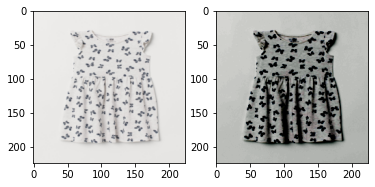

In [8]:
_, axarr = plt.subplots(1, 2)
axarr[0].imshow(tens_scaled.permute(1, 2, 0))
axarr[1].imshow(tens_centered.permute(1, 2, 0))

___

Test lightning data module

In [9]:
data_module = HMDataModule(
        data_path=cfg.get('data_path'),
        batch_size=cfg.get('batch_size'),
        image_size=cfg.get('image_size'),
        center=cfg.get('center'),
        center_params=cfg.get('center_params')
)

In [10]:
data_module.train_valid_ratio

0.9

In [11]:
data_module.center_params

{'mean': [0.7662, 0.7482, 0.7468], 'std': [0.2005, 0.2172, 0.2129]}

In [12]:
str(data_module.center_params)

"{'mean': [0.7662, 0.7482, 0.7468], 'std': [0.2005, 0.2172, 0.2129]}"

---

In [13]:
data_valid = HMDataset(
    data_path=os.path.join(cfg.get('data_path'), 'valid'),
    image_size=cfg.get('image_size'),
    center=cfg.get('center'),
    center_params=cfg.get('center_params')
)

In [14]:
data_module = HMDataModule(
    data_path=cfg.get('data_path'),
    batch_size=cfg.get('batch_size'),
    num_workers=cfg.get('num_workers'),
    image_size=cfg.get('image_size'),
    center=cfg.get('center'),
    center_params=cfg.get('center_params')
)

In [15]:
model = LitHMAutoEncoder(
    optimizer=getattr(import_module('torch.optim'), cfg.get('optimizer')),
    optimizer_params=cfg.get('optimizer_params'),
    encoder=getattr(import_module('model.encoders'), cfg.get('encoder'))(cfg.get('image_size')),
    decoder=getattr(import_module('model.decoders'), cfg.get('decoder'))(cfg.get('image_size')),
    # run=run
)

In [16]:
trainer = pl.Trainer(
    max_epochs=cfg.get('num_epochs'),
    gpus=cfg.get('num_gpus'),
    num_sanity_val_steps=0
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [17]:
trainer.fit(model, data_module)


  | Name    | Type        | Params
----------------------------------------
0 | encoder | EncoderBase | 19.3 M
1 | decoder | DecoderBase | 19.4 M
----------------------------------------
38.7 M    Trainable params
0         Non-trainable params
38.7 M    Total params
154.777   Total estimated model params size (MB)
/opt/miniconda3/envs/image-embeddings/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/miniconda3/envs/image-embeddings/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 whic

Epoch 2: 100%|██████████| 64/64 [00:30<00:00,  2.10it/s, loss=0.041, v_num=78] 


In [18]:
iter(data_module.train_dataloader())

In [19]:
def imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.pause(1)
    plt.close()

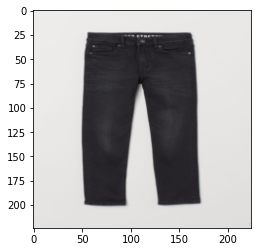

In [20]:
imshow(data_valid[0])

In [21]:
data_iter = iter(data_module.val_dataloader())

In [22]:
sample_size = 10

In [24]:
sample_images = data_iter.next()[:sample_size, :, :, :]
sample_images.shape

torch.Size([10, 3, 224, 224])

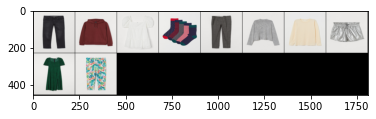

In [25]:
imshow(torchvision.utils.make_grid(sample_images))

In [26]:
model.freeze()
model.eval()
embeddings = model.encoder(sample_images.reshape(sample_size, data_module.image_size[0]*data_module.image_size[1]*3))
embeddings.shape

torch.Size([10, 32])

In [27]:
decoded_sample_images = model.decoder(embeddings).reshape(sample_size, 3, data_module.image_size[0], data_module.image_size[1])
decoded_sample_images.shape

torch.Size([10, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


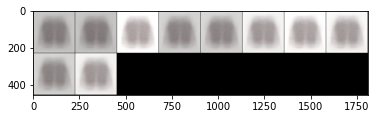

In [28]:
imshow(torchvision.utils.make_grid(decoded_sample_images))